In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
def load_data_by_dimension(dimension):
    root="./datasets/"
    data_filename = root+f'kryptonite-{dimension}-X.npy'
    labels_filename = root+f'kryptonite-{dimension}-y.npy'

    try:
        data = np.load(data_filename)
        labels = np.load(labels_filename)
        print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
        return data, labels
    except FileNotFoundError:
        print(f"Dataset for dimension {dimension} not found.")
        return None, None

In [3]:
def preprocess_data(data, variance_threshold=0.253):
      variances = np.var(data, axis=0)
      return data[:, variances > variance_threshold]

In [4]:
def plot_optimal_k(dim):
  data, labels = load_data_by_dimension(dim)
  data =  preprocess_data(data, variance_threshold=0.253)

  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
  krange = list(range(1,30,2))+[35,45,55,65,75,85,95,101]
  accuracies=[]
  for k in krange:
    model = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(model, X_train, y_train, cv=5)
    accuracies.append(np.mean(acc))
  plt.rcdefaults()
  plt.figure(figsize=(10, 5))
  plt.plot(krange, accuracies, marker='o', linestyle='-', color='b')
  plt.xlabel('Value of K')
  plt.ylabel('Accuracy')
  plt.title(f'kNN Performance for different K (dim={dim})')
  plt.grid(True)
  plt.show()

## kryptonite-9

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


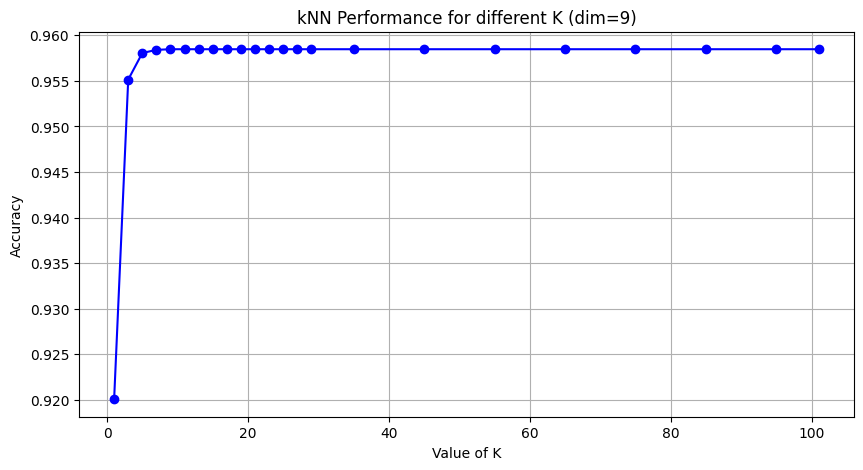

In [5]:
plot_optimal_k(9)

## kryptonite-12

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


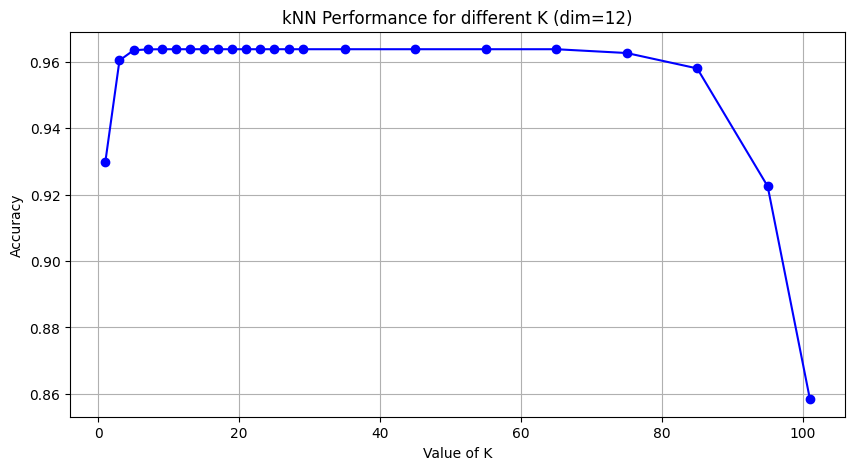

In [6]:
plot_optimal_k(12)

## kryptonite-15

In [ ]:
plot_optimal_k(15)

## kryptonite-18

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


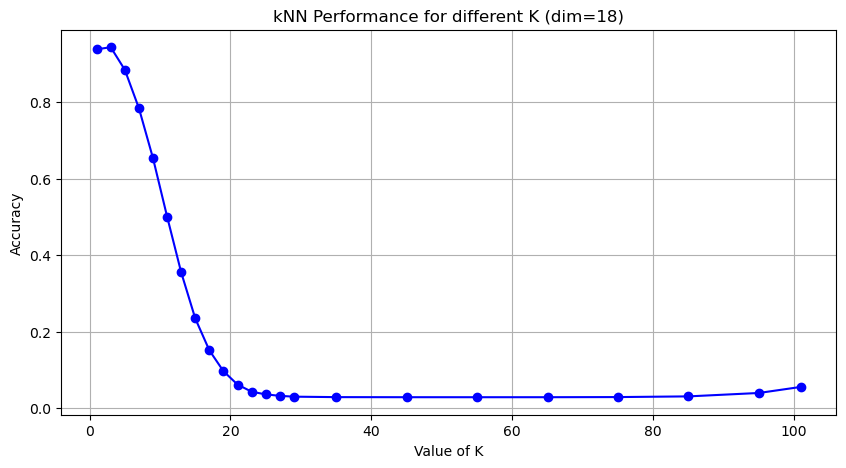

In [ ]:
plot_optimal_k(18)

## kryptonite-24


Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


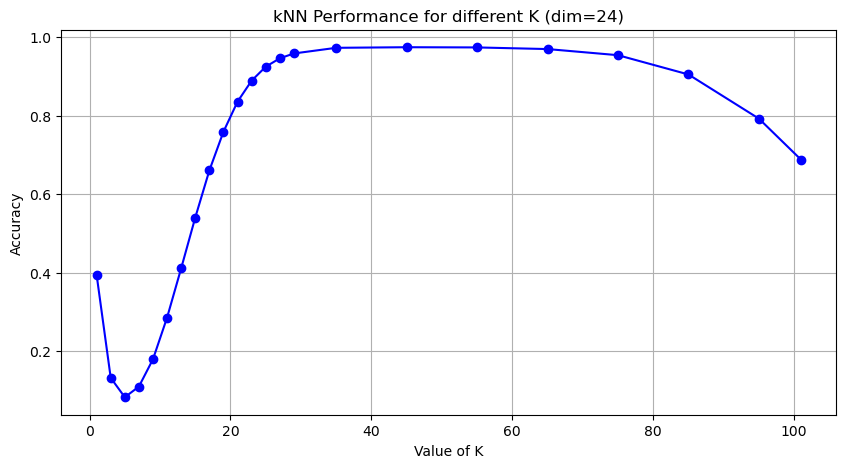

In [ ]:
plot_optimal_k(24)

## kryptonite-30

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


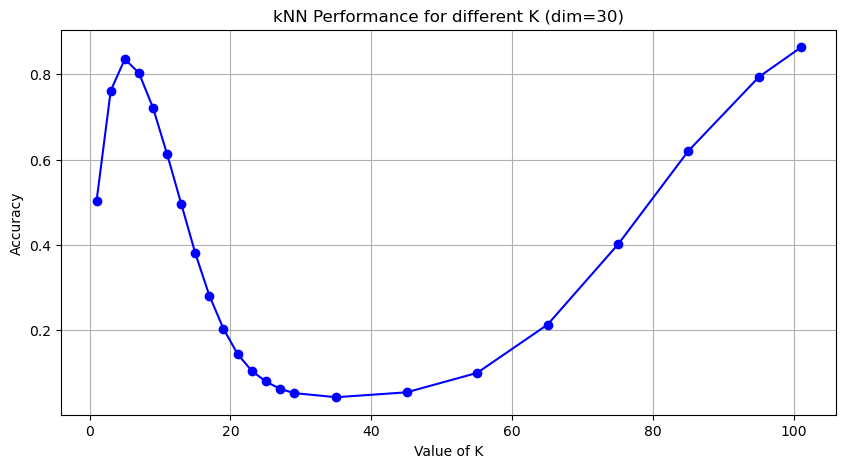

In [ ]:
plot_optimal_k(30) # the model basically predicts the label the datapoint is not in at k-45, thus should flip the ouput

## kryptonite-45

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


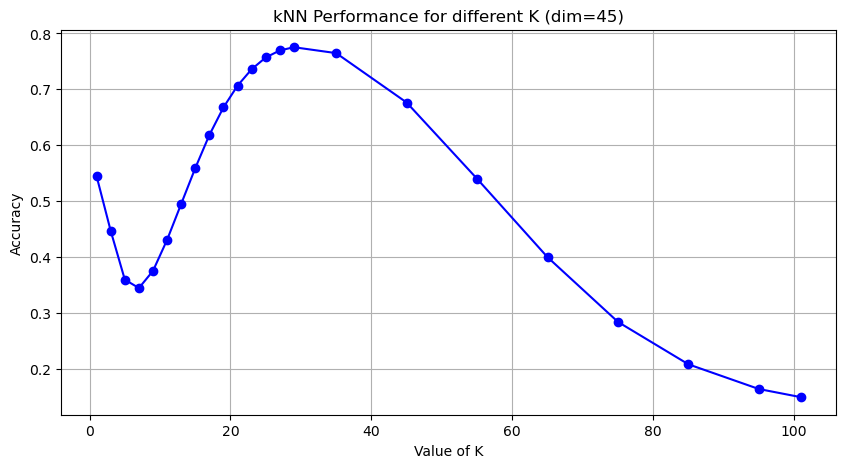

In [ ]:
plot_optimal_k(45)

In [5]:
best_ks=[9,5,5,3,35,45,35]
dimensions=[9,12,15,18,24,30,45]
Knn_models=[]
accuracies=[]
means = []
std_devs = []
for dim , k in zip(dimensions,best_ks):
  data, labels = load_data_by_dimension(dim)
  data = preprocess_data(data, variance_threshold=0.253)
  accuracies = []
  for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    if dim == 30: # the model basically predicts the label the datapoint is not in at dim=30 and k=45, thus should flip the output
      y_pred=1-y_pred
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
  means.append(np.mean(accuracies))
  std_devs.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


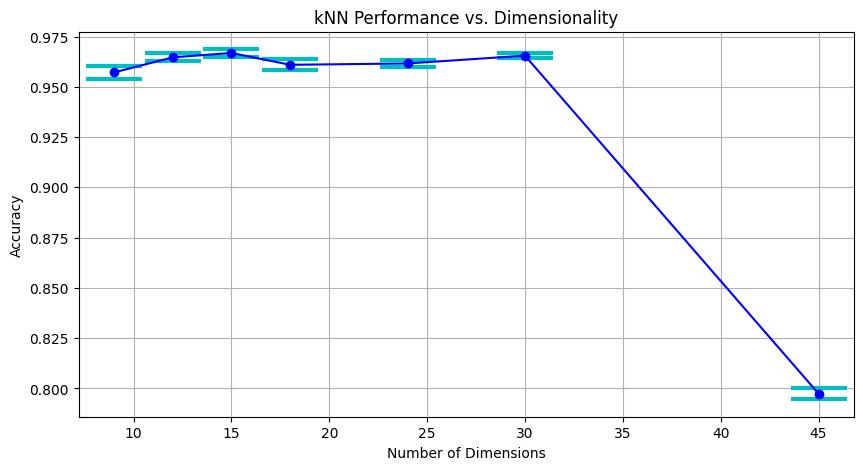

In [6]:
plt.figure(figsize=(10, 5))
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('kNN Performance vs. Dimensionality')
plt.grid(True)
plt.show()

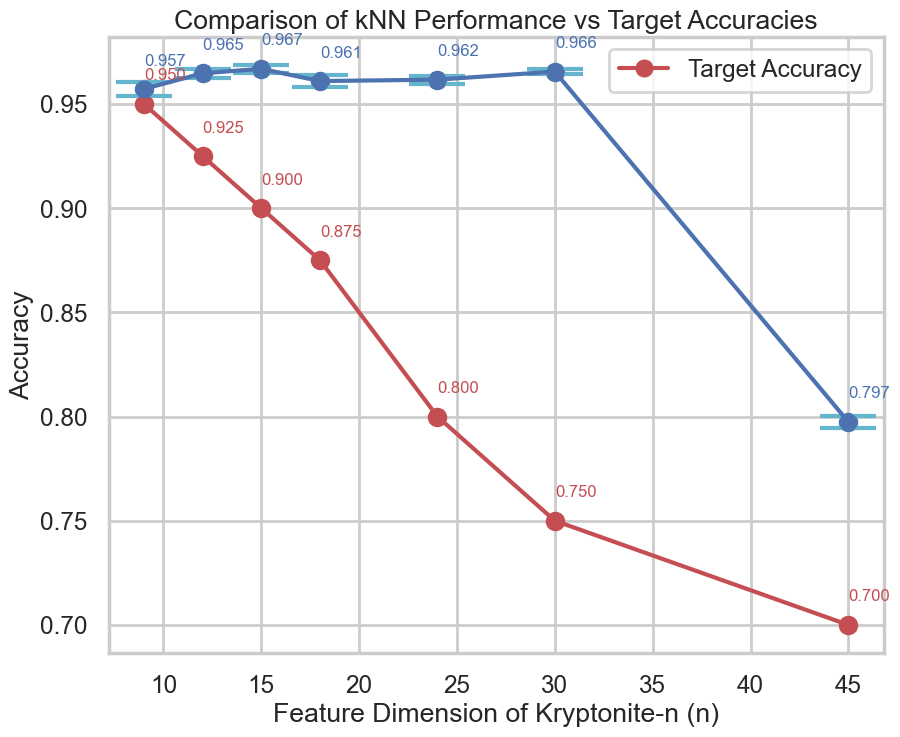

In [7]:
import seaborn as sns
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.scatter(dimensions, means, color='b')

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
plt.scatter(n, target_accuracies, color='r')

# Annotating target accuracies
ax = plt.gca()
for j, (x, y) in enumerate(zip(n, target_accuracies)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='r', size=12)
for j, (x, y) in enumerate(zip(n, means)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='b', size=12)

# Titles and labels
plt.title("Comparison of kNN Performance vs Target Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Feature Dimension of Kryptonite-n (n)")
plt.legend()

# Show the plot
plt.show()


In [9]:
best_ks=[9,5,5,3,35,45,35]
dimensions=[9,12,15,18,24,30,45]
root="./datasets/"
for dim , k in zip(dimensions,best_ks):
  data, labels = load_data_by_dimension(dim)
  data = preprocess_data(data, variance_threshold=0.253)

  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(data, labels)

  data_filename = root+f'hidden-kryptonite-{dim}-X.npy'
  hidden_data = np.load(data_filename)
  hidden_data = preprocess_data(hidden_data, variance_threshold=0.253)
  y_pred = model.predict(hidden_data)
  if dim in [30]:
    y_pred=1-y_pred
  np.save(f'y_predicted_{dim}.npy', y_pred)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
